In [18]:
import sys, time, os, random
import numpy as np
import pandas as pd
from bitstring import BitArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(0)

from deap import base, creator, tools, algorithms

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import bernoulli

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.utils import to_categorical
# from tensorboard.plugins.hparams import api as hp
# from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

# import deap

sys.path.append("/home/isidro/Documents/github/SimpleMC/")
from simplemc.plots.plot_Quintom_variables import *
from simplemc.models.QuintomCosmology import QuintomCosmology
from simplemc.models.LCDMCosmology import LCDMCosmology
from simplemc.cosmo.Parameter import Parameter

In [19]:
om_ = Parameter("Om", 0.3038, 0.05, (0.1, 0.5), "\Omega_m")
obh2_ = Parameter("Obh2", 0.02234, 0.001, (0.02, 0.025), "\Omega_{b}h^2")
h_ = Parameter("h", 0.6821, 0.05, (0.4, 0.9), "h")
mquin_ = Parameter("mquin", 1.7, 0.2, (0, 4.0), "m_{\phi}")
mphan_ = Parameter("mphan", 0.8, 0.2, (0, 3.0), "m_{\psi}")
iniphi_ = Parameter("iniphi", 0.5, 0.1, (0, 1.5), "\phi_0")
coupling_ = Parameter("beta",  1.0, 0.5, (-10, 10), "\\beta")

In [20]:
minim, maxim = (0.1, 2.5)

T = QuintomCosmology(vary_mquin=True)

ww = []
# dd = []
X = []
Y = []
mquin_data = np.arange(0, 4, 0.5)

for i, val in enumerate(mquin_data):
#     if fname == 'Quintessence':
    mquin_.setValue(val)
    T.updateParams([mquin_])

    T.call_functions()
    zl = np.arange(0.0, 3.5, 0.01)
    wlist = []
    for z in zl:
        X.append([z, val])
        eos = T.w_de(1./(1+z))
        wlist.append(eos)
        Y.append(eos)
    ww.append(wlist)       
#     print(ww[i])

X = np.array(X)
Y = np.array(Y)

In [21]:
np.shape(ww), np.shape(mquin_data), np.shape(zl), np.shape(X), np.shape(Y)

((8, 350), (8,), (350,), (2800, 2), (2800,))

(-1.05, 1.1)

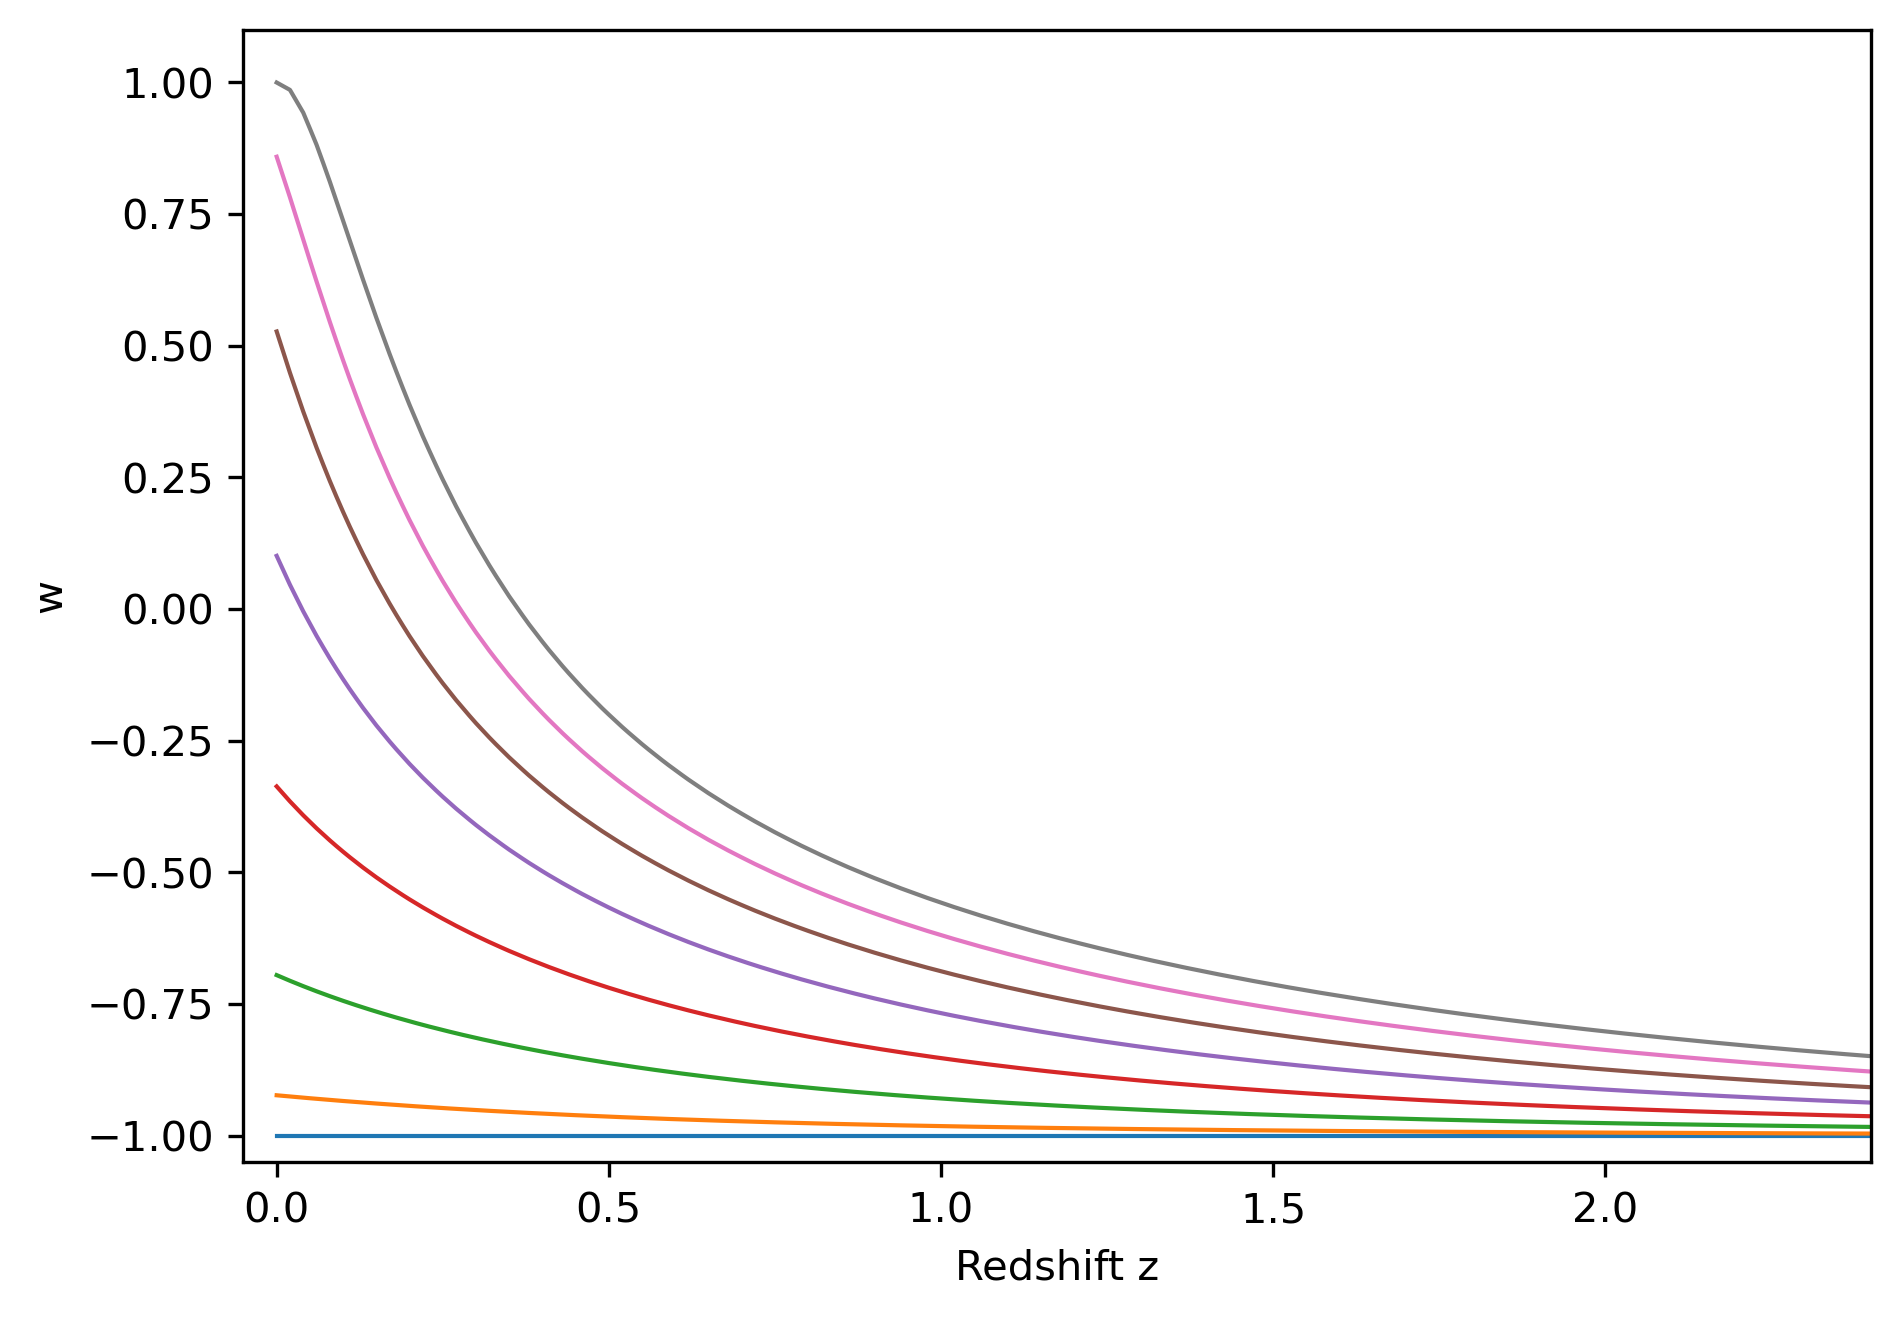

In [22]:
fig = plt.figure(figsize=(7,5), dpi=300)

for line in ww:
    plt.plot(zl, line, alpha=1, lw=1)

plt.xlabel("Redshift z")
plt.ylabel("w")
plt.xlim(-0.05, 2.4)
plt.ylim(-1.05, 1.1)
# plt.hlines(-1, xmin=0, xmax=3.05, colors='red',  linestyles='dashed', label='$w=-1$', lw=3, alpha=1)

In [31]:
epochs=100
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=500,
                                   restore_best_weights=True, verbose=False)
                                   ]

In [24]:
#Separamos los datos en validación y entrenamiento
ntrain = int(0.8 * len(Y))
indx = [ntrain]
shuffle = np.random.permutation(len(X))
X = X[shuffle]
Y = Y[shuffle]
X_train, X_val = np.split(X, indx)
Y_train, Y_val = np.split(Y, indx)
# nval = int(0.5*(len(X_test)))
# indx_val = [nval]
# X_val, X_test = np.split(X_test, indx_val)
# Y_val, Y_test = np.split(Y_test, indx_val)

In [25]:
np.shape(X_train), np.shape(Y_train), np.shape(X_val), np.shape(Y_val)

((2240, 2), (2240,), (560, 2), (560,))

In [26]:
SC_DEEP       = np.array([1, 2, 3, 4])                           # Number of deep layers (8)
SC_NUM_UNITS  = np.array([50,100,150,200]) # Number of fully conected neurons (16)
SC_LEARNING   = np.array([1e-4,1e-3])   # Learning rates (8)
SC_BATCH      = np.array([8, 16]) 

In [32]:
def train_evaluate(ga_individual_solution):   
    t = time.time()
    t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits   = BitArray(ga_individual_solution[0:2])     # (8)
    num_units_bits     = BitArray(ga_individual_solution[2:4])     # (16)
    learning_rate_bits = BitArray(ga_individual_solution[4:5])    # (8)
    batch_size_bits    = BitArray(ga_individual_solution[5:6])   # (4)
# #     activation_f_bits  = BitArray(ga_individual_solution[12:13])   # (2)   Solo se consideran las 2 primeras
    
    deep_layers   = SC_DEEP[deep_layers_bits.uint]
    num_units     = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
    batch_size   = SC_BATCH[batch_size_bits.uint]
#     activation_f  = SC_ACTIVATION[activation_f_bits.uint]

    
    print('\n--------------- Starting trial:', population_size*(max_generations+1)-len(ss), "---------------")
    print('Deep layers:',deep_layers,', Number of neurons:',num_units,", Learning rate:",learning_rate)
#     print("-------------------------------------------------")
    
    # Train model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(deep_layers):        
        model.add(Dense(num_units, activation='relu'))
#             model.add(keras.layers.Dropout(0.3))
    model.add(Dense(4, activation='linear'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=callbacks, batch_size=batch_size, shuffle=False, verbose=0)
    
    loss, score = model.evaluate(X_val, Y_val)    
    t = time.time()-t
    ss.pop(0)
    print("Loss:", score, ", Elapsed time:", t)
    print("-------------------------------------------------\n")
#     print(loss, score)

    datos.append([deep_layers, num_units, learning_rate, batch_size, loss, score, t])
    
    return loss,

In [33]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [34]:
def geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k):
    
    # Genetic Algorithm constants:
    P_CROSSOVER = 0.8        # probability for crossover
    P_MUTATION = 0.2         # probability for mutating an individual
    HALL_OF_FAME_SIZE = 1    # Best individuals that pass to the other generation
    
    # set the random seed:
    toolbox = base.Toolbox()

    # As we are trying to minimize the RMSE score, that's why using -1.0. 
    # In case, when you want to maximize accuracy for instance, use 1.0
    creator.create('FitnessMin', base.Fitness, weights = [-1.0])
    creator.create('Individual', list , fitness = creator.FitnessMin)

    # create the individual operator to fill up an Individual instance:
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)

    # create the population operator to generate a list of individuals:
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    # genetic operators:
    toolbox.register('evaluate', train_evaluate)
    toolbox.register('select', tools.selTournament, tournsize = 2)
    toolbox.register('mutate', tools.mutFlipBit, indpb = 0.11)
    toolbox.register('mate', tools.cxUniform, indpb = 0.5)
    
    # create initial population (generation 0):
    population = toolbox.population(n=population_size)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Genetic Algorithm flow with elitism:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=max_generations, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    # extract statistics:
    minFitnessValues, meanFitnessValues, maxFitnessValues = logbook.select("min", "max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='blue', label="Min")
    plt.plot(meanFitnessValues, color='green', label="Mean")
    plt.plot(maxFitnessValues, color='red', label="Max")
    plt.xlabel('Generation'); plt.ylabel('Max / Min / Average Fitness')
    plt.legend()
    plt.title('Max, Min and Average fitness over Generations')
    plt.show()
    
    best_population = tools.selBest(population,k = k)
    return best_population

In [ ]:
population_size = 11   # max of individuals per generation
max_generations = 5    # number of generations
gene_length = 6      # lenght of the gene, depends on how many hiperparameters are tested  
k = 1;                 # num. of finalist individuals

if __name__ == "__main__":
    t = time.time(); 
    datos = [];
    ss = [i for i in range(1,population_size*(max_generations+1))]
    best_population = geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k)
    print("Total elapsed time:", (time.time()-t)/60, "minutes")


--------------- Starting trial: 1 ---------------
Deep layers: 2 , Number of neurons: 100 , Learning rate: 0.001
18/18 [==============================] - 0s 867us/step - loss: 1.2876e-05 - mean_squared_error: 1.2876e-05
Loss: 1.287580107600661e-05 , Elapsed time: 28.555842638015747
-------------------------------------------------


--------------- Starting trial: 2 ---------------
Deep layers: 1 , Number of neurons: 100 , Learning rate: 0.001
18/18 [==============================] - 0s 743us/step - loss: 1.2764e-04 - mean_squared_error: 1.2764e-04
Loss: 0.00012763611448463053 , Elapsed time: 25.807268619537354
-------------------------------------------------


--------------- Starting trial: 3 ---------------
Deep layers: 1 , Number of neurons: 50 , Learning rate: 0.001
18/18 [==============================] - 0s 829us/step - loss: 3.0920e-04 - mean_squared_error: 3.0920e-04
Loss: 0.0003091977268923074 , Elapsed time: 14.032310724258423
----------------------------------------------